### 3 way venn would be K562 IDR, PSLBP peaks (union or IDR if we have, though i think whatever is fastest to check, because i think Gene is now worried about PSLBP* being underanalyzed for submission), and then these 2 filtering outputs i'll paste in a second.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3, venn2_unweighted, venn3_unweighted
import seaborn as sns
import pandas as pd
import numpy as np
import gffutils
import glob
import os
import pybedtools
from scipy import stats

## These files were all annotated the same way. using /home/bay001/projects/kris_apobec_20200121/permanent_data/rebuttal/inputs/annotate_peaks_bedformat_wproxdistal_lncRNA.pl, with exception of ```histone_genes_file``` which are just genes

In [2]:
# histone_genes_file = '/home/rmarina/projects/apobec/ref_files/histone_genes.bed'
histone_genes_file = '/home/rmarina/projects/apobec/ref_files/hgnc_histone_genes.txt'
k562_idr_peaks_file = '/home/bay001/projects/kris_apobec_20200121/reference_data/SLBP_K562_IDR.sorted.merged.bed.annotated_proxdist_miRlncRNA'
pslbp_idr_peaks_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20200228_kris_eclip/IDR/kris_apobec/annotate/inputs/PSLBP_1.vs.PSLBP_2.bed.annotated_proxdist_miRlncRNA'
stamp_edits_poisson05_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/rebuttal/from_eric/SLBP_1000_merged_filtered_merged_score_0.5_poisson_boost_10_density.tsv.bed.annotated_proxdist_miRlncRNA'
stamp_edits_poisson075_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/rebuttal/from_eric/SLBP_1000_merged_filtered_merged_score_0.75_poisson_boost_10_density.tsv.bed.annotated_proxdist_miRlncRNA'
stamp_edits_poisson05_no_density_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/rebuttal/from_eric/SLBP_1000_merged_filtered_merged_score_0.5_poisson_boost_10_no_density.tsv.bed.annotated_proxdist_miRlncRNA'
stamp_edits_poisson075_no_density_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/rebuttal/from_eric/SLBP_1000_merged_filtered_merged_score_0.75_poisson_boost_10_no_density.tsv.bed.annotated_proxdist_miRlncRNA'
unfiltered_edits_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/rebuttal/inputs/SLBP_1000_72hr_merged_a0_b0_e0.01.bed.annotated_proxdist_miRlncRNA'
counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/featurecounts/counts.overlapping.multimapping.txt'  # Do multimapping and overlapping to catch every single read, since I noticed that histone gnes sometimes overlap...
stamp_control_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/rebuttal/inputs/SLBP_0_72hr_merged_a0_b0_e0.01.bed.annotated_proxdist_miRlncRNA'
annotation = 'Ensembl' # or "Gencode". This controls the annotations (whether we use ENSG00000012345.1 or ENSG00000012345)

# The strategy for venns is simply use a gene overlap for a first pass.

In [3]:
names = ['chrom','start','end','name','score','strand','annotation','region_w_gene','geneid','genename','region_w_overlap']

k562_idr = pd.read_csv(k562_idr_peaks_file, sep='\t', names=names)
pslbp_idr = pd.read_csv(pslbp_idr_peaks_file, sep='\t', names=names)
stamp_edits_poisson05 = pd.read_csv(stamp_edits_poisson05_file, sep='\t', names=names)
stamp_edits_poisson075 = pd.read_csv(stamp_edits_poisson075_file, sep='\t', names=names)
stamp_edits_poisson05_no_density = pd.read_csv(stamp_edits_poisson05_no_density_file, sep='\t', names=names)
stamp_edits_poisson075_no_density = pd.read_csv(stamp_edits_poisson075_no_density_file, sep='\t', names=names)
unfiltered_edits = pd.read_csv(unfiltered_edits_file, sep='\t', names=names)
stamp_control = pd.read_csv(stamp_control_file, sep='\t', names=names)
stamp_control.tail()

,chrom,start,end,name,score,strand,annotation,region_w_gene,geneid,genename,region_w_overlap
80323,chrM,13414,13415,0.662282,"1,42",-,NaN,intergenic,NaN,NaN,intergenic|1
80324,chrM,13889,13890,0.000000,"30,30",-,NaN,intergenic,NaN,NaN,intergenic|1
80325,chrM,14580,14581,0.000000,"22,22",-,CDS;ENSG00000198695.2,CDS||ENSG00000198695.2,ENSG00000198695.2,MT-ND6,CDS|1
80326,chrM,15466,15467,0.000000,"34,34",-,NaN,intergenic,NaN,NaN,intergenic|1
80327,chrM,16504,16505,0.655659,"1,43",-,NaN,intergenic,NaN,NaN,intergenic|1


### As a sanity check, let's just use basic filtering (conf, maybe drop intergenic edits) to see if the comparisons match.

In [4]:
filtered_edits = unfiltered_edits[unfiltered_edits['name'] >= 0.]  # Some arbitrary cutoff
filtered_edits['editfrac'] = filtered_edits['score'].apply(lambda x: int(x.split(',')[0])/float(x.split(',')[1]))
print(filtered_edits.shape[0])
filtered_edits.dropna(inplace=True)
print(filtered_edits.shape[0])
filtered_edits.head()

103082
100351


,chrom,start,end,name,score,strand,annotation,region_w_gene,geneid,genename,region_w_overlap,editfrac
0,chr1,322208,322209,0.904382,"1,11",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.090909
1,chr1,324297,324298,0.972277,"2,27",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.074074
2,chr1,324779,324780,0.922745,"1,9",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.111111
3,chr1,324820,324821,0.817907,"1,21",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.047619
4,chr1,327502,327503,0.886385,"1,13",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||ENSG00000250575.1||lncRNA|lnc-...,ENSG00000250575.1||lncRNA|lnc-OR4F29-1,RP4-669L17.8|lnc-OR4F29-1,noncoding_exon|1,0.076923


In [5]:
def trim_lncrna_annotations(row, a=annotation):
    """
    The eCLIP annotation script also annotates lncRNA and miRs, but I just
    really care about the gencode annotations, since that's easier to manage 
    across multiple datasets than these others.
    """
    if type(row['geneid']) == float:  # intergenic, has NaN for geneid
        return 'intergenic'
    if '||' not in row['geneid']:
        if a == 'Ensembl':
            return row['geneid'].split('.')[0]
        else:
            return row['geneid']
    else:
        for annotation in row['geneid'].split('||'):
            if 'ENSG' in annotation:
                if a == 'Ensembl':
                    return annotation.split('.')[0]  # to deal with comparing to the HGNC annotations.
                else:
                    return annotation
    return row['geneid']

k562_idr['geneid_trimmed'] = k562_idr.apply(trim_lncrna_annotations, args=(annotation, ), axis=1)
pslbp_idr['geneid_trimmed'] = pslbp_idr.apply(trim_lncrna_annotations, args=(annotation, ), axis=1)
stamp_edits_poisson05['geneid_trimmed'] = stamp_edits_poisson05.apply(trim_lncrna_annotations, args=(annotation, ), axis=1)
stamp_edits_poisson075['geneid_trimmed'] = stamp_edits_poisson075.apply(trim_lncrna_annotations, args=(annotation, ), axis=1)
stamp_edits_poisson05_no_density['geneid_trimmed'] = stamp_edits_poisson05_no_density.apply(trim_lncrna_annotations, args=(annotation, ), axis=1)
stamp_edits_poisson075_no_density['geneid_trimmed'] = stamp_edits_poisson075_no_density.apply(trim_lncrna_annotations, args=(annotation, ), axis=1)
stamp_control['geneid_trimmed'] = stamp_control.apply(trim_lncrna_annotations, args=(annotation, ), axis=1)
filtered_edits['geneid_trimmed'] = filtered_edits.apply(trim_lncrna_annotations, args=(annotation, ), axis=1)
filtered_edits.head()

,chrom,start,end,name,score,strand,annotation,region_w_gene,geneid,genename,region_w_overlap,editfrac,geneid_trimmed
0,chr1,322208,322209,0.904382,"1,11",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.090909,ENSG00000237094
1,chr1,324297,324298,0.972277,"2,27",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.074074,ENSG00000237094
2,chr1,324779,324780,0.922745,"1,9",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.111111,ENSG00000237094
3,chr1,324820,324821,0.817907,"1,21",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.047619,ENSG00000237094
4,chr1,327502,327503,0.886385,"1,13",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||ENSG00000250575.1||lncRNA|lnc-...,ENSG00000250575.1||lncRNA|lnc-OR4F29-1,RP4-669L17.8|lnc-OR4F29-1,noncoding_exon|1,0.076923,ENSG00000250575


### Using 'histone genes' as a positive ctrl

In [6]:
histone_genes0 = pd.read_csv('/home/rmarina/projects/apobec/ref_files/histone_genes.bed', sep='\t', names=['chrom','start','end','name','score','strand'])  # let's see how much this overlaps with the other 'histone' set.
histone_genes = pd.read_csv(histone_genes_file, sep='\t')
histone_genes = histone_genes[histone_genes['Locus type']=='gene with protein product']
print(histone_genes.shape[0])
histone_genes.head()

93


,HGNC ID,Approved symbol,Approved name,Status,Locus type,Previous symbols,Alias symbols,Chromosome,NCBI Gene ID,Ensembl gene ID,Vega gene ID,Group ID,Group name
0,HGNC:4714,H1-0,H1.0 linker histone,Approved,gene with protein product,"H1FV, H1F0",H1.0,22q13.1,3005,ENSG00000189060,OTTHUMG00000150659,1935,H1 histones
1,HGNC:4715,H1-1,"H1.1 linker histone, cluster member",Approved,gene with protein product,"H1F1, HIST1H1A","H1.1, H1a",6p22.2,3024,ENSG00000124610,OTTHUMG00000016413,1935,H1 histones
2,HGNC:4722,H1-10,H1.10 linker histone,Approved,gene with protein product,H1FX,"MGC15959, MGC8350, H1X",3q21.3,8971,ENSG00000184897,OTTHUMG00000159450,1935,H1 histones
4,HGNC:4716,H1-2,"H1.2 linker histone, cluster member",Approved,gene with protein product,"H1F2, HIST1H1C","H1.2, H1s-1, H1c",6p22.2,3006,ENSG00000187837,OTTHUMG00000016140,1935,H1 histones
5,HGNC:4717,H1-3,"H1.3 linker histone, cluster member",Approved,gene with protein product,"H1F3, HIST1H1D","H1.3, H1d, H1s-2",6p22.2,3007,ENSG00000124575,OTTHUMG00000014432,1935,H1 histones


In [7]:
histone_genes0['Ensembl gene ID'] = histone_genes0['name'].apply(lambda x: x.split('.')[0])
histone_genes0.head()

,chrom,start,end,name,score,strand,Ensembl gene ID
0,chr1,120904674,120905090,ENSG00000213244.3,HIST2H3DP1,+,ENSG00000213244
1,chr1,120906027,120915073,ENSG00000223345.3,HIST2H2BA,+,ENSG00000223345
2,chr1,149369721,149399226,ENSG00000240929.2,HIST2H2BB,-,ENSG00000240929
3,chr1,149400130,149400542,ENSG00000203818.6,HIST2H3PS2,-,ENSG00000203818
4,chr1,149754244,149783928,ENSG00000203814.5,HIST2H2BF,-,ENSG00000203814


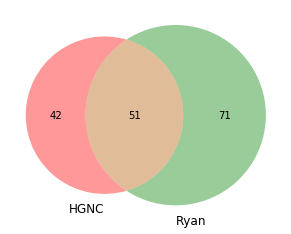

In [8]:
venn2([set(histone_genes['Ensembl gene ID']), set(histone_genes0['Ensembl gene ID'])], ['HGNC', 'Ryan'])

# It's weird that there isn't more overlap between the two histone genesets. Maybe take the union and then intersect this unioned geneset with the expressed genes in (any) of the SLBP replicates.

# Just spot checking here/there... there seems to be a number of pseudogenes (ie. ENSG00000233733.1) that made it into the histone genes file? /home/rmarina/projects/apobec/ref_files/histone_genes.bed
- So there are about 20 genes in total (out of 122) that seem to not be expressed. That's weird, but excluding these might help us get better overlap. 
- Need to check with Kris and Ryan to see what those genes are (if pseudogenes, do we count them? Where did this file come from?) and if they're worth counting. For comparison to eCLIP maybe we should, but if genes aren't expressed they simply won't be edited.

In [9]:
set(histone_genes['Ensembl gene ID']).difference(set(histone_genes0['Ensembl gene ID']))

{'ENSG00000115163',
 'ENSG00000268799',
 'ENSG00000269466',
 'ENSG00000270276',
 'ENSG00000270882',
 'ENSG00000272196',
 'ENSG00000273213',
 'ENSG00000273542',
 'ENSG00000273703',
 'ENSG00000273802',
 'ENSG00000273983',
 'ENSG00000274183',
 'ENSG00000274290',
 'ENSG00000274618',
 'ENSG00000274641',
 'ENSG00000274750',
 'ENSG00000274997',
 'ENSG00000275126',
 'ENSG00000275221',
 'ENSG00000275379',
 'ENSG00000275663',
 'ENSG00000275713',
 'ENSG00000275714',
 'ENSG00000276180',
 'ENSG00000276368',
 'ENSG00000276410',
 'ENSG00000276903',
 'ENSG00000276966',
 'ENSG00000277075',
 'ENSG00000277157',
 'ENSG00000277224',
 'ENSG00000277745',
 'ENSG00000277775',
 'ENSG00000277858',
 'ENSG00000278463',
 'ENSG00000278588',
 'ENSG00000278637',
 'ENSG00000278677',
 'ENSG00000278705',
 'ENSG00000278828',
 'ENSG00000286522',
 'ENSG00000287080'}

# Look at the readcounts for genes within the SLBP dataset, and filter the unioned histone set for genes that are expressed only.

In [10]:
def counts_to_rpkm(feature_counts_table):
    counts = feature_counts_table.ix[:,5:]
    lengths = feature_counts_table['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def counts_to_tpm(counts_table, skip_col=5):
    """
    simple function that converts a featureCounts pandas Dataframe
    into a TPM dataframe.
    
    :param counts_table: pandas.DataFrame() 
        either a featureCounts table (first five cols contain non-count info,
        the rest contain raw counts) or a generic counts table (use skip_col=0
        in this case)
    :return tpm: pandas.DataFrame
    """
    rpkm = counts_to_rpkm(counts_table)
    tpm = rpkm.div(rpkm.sum())*pow(10,6)
    return tpm

counts_table = pd.read_csv(counts_file, index_col=0, skiprows=1, sep='\t')

tpm = counts_to_tpm(counts_table)
tpm.columns = [c.replace('/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/','').replace('.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam','') for c in tpm.columns]
tpm.head()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,APOBEC_only_0_merged_R1,APOBEC_only_1000_merged_R1,APOBEC_only_50_merged_R1,RBFOX_0_48hr_merged_R1,RBFOX_0_72hr_merged_R1,RBFOX_1000_48hr_merged_R1,RBFOX_1000_72hr_merged_R1,RBFOX_50_48hr_merged_R1,RBFOX_50_72hr_merged_R1,SLBP_0_72hr_A_merged_R1,SLBP_0_72hr_B_merged_R1,SLBP_0_72hr_C_merged_R1,SLBP_1000_48hr_A_merged_R1,SLBP_1000_48hr_B_merged_R1,SLBP_1000_48hr_C_merged_R1,SLBP_1000_72hr_A_merged_R1,SLBP_1000_72hr_B_merged_R1,SLBP_1000_72hr_C_merged_R1
Geneid,,,,,,,,,,,,,,,,,,
ENSG00000223972.4,0.230791,0.043281,0.040826,0.214849,0.095042,0.260153,0.059797,0.117453,0.181782,0.139695,0.051710,0.033809,0.176302,0.078895,0.109704,0.246414,0.153635,0.156688
ENSG00000227232.4,64.392447,64.196832,57.407869,56.054455,61.454583,45.963025,34.418613,37.127100,81.580652,40.327904,42.992204,42.901324,51.757602,61.172489,49.661046,61.963881,55.006566,60.735964
ENSG00000243485.2,2.034285,1.712099,1.895836,2.401853,2.124990,1.278378,0.822749,1.380366,1.500687,0.768829,1.156156,0.639625,2.425744,3.075658,2.150938,1.574128,1.277135,2.101978
ENSG00000237613.2,0.041558,0.062348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052372,0.000000,0.074489,0.146109,0.072562,0.000000,0.063213,0.000000,0.000000,0.045142
ENSG00000268020.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046702,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
def gene_id_to_protein_coding(db):
    """
    returns whether or not a gene is protein coding or not.
    """
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['gene_id'][0] if type(gene.attributes['gene_id']) == list else gene.attributes['gene_id']
        try:
            gene_name_dict[gene_id] = gene.attributes['gene_type'][0]
        except KeyError:
            print(gene.attributes.keys())
            print("Warning. Key not found for {}".format(gene))
            return 1
    return gene_name_dict

db_file = '/projects/ps-yeolab3/bay001/annotations/hg19/gencode_v19/gencode.v19.annotation.gtf.db'
DATABASE = gffutils.FeatureDB(db_file)

gene_id_to_pc = gene_id_to_protein_coding(DATABASE)
gene_id_to_pc['ENSG00000100320.18']  # test the func

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


'protein_coding'

In [12]:
def geneid2pc(row, d=gene_id_to_pc):
    try:
        return d[row['Geneid']]
    except KeyError:
        return 'intergenic'

In [13]:
# some hacky stuff to get around our Ensembl vs Gencode annotation problem.
if annotation == 'Ensembl':
    tpm.reset_index(inplace=True)
    tpm['Ensembl gene ID'] = tpm['Geneid'].apply(lambda x: x.split('.')[0])
    tpm['pc'] = tpm.apply(geneid2pc, axis=1)
    del tpm['Geneid']
    tpm.set_index('Ensembl gene ID', inplace=True)
    tpm.index.names = ['Geneid']

    counts_table.reset_index(inplace=True)
    counts_table['Ensembl gene ID'] = counts_table['Geneid'].apply(lambda x: x.split('.')[0])
    del counts_table['Geneid']
    counts_table.set_index('Ensembl gene ID', inplace=True)
    counts_table.index.names = ['Geneid']
    
tpm.head()

,APOBEC_only_0_merged_R1,APOBEC_only_1000_merged_R1,APOBEC_only_50_merged_R1,RBFOX_0_48hr_merged_R1,RBFOX_0_72hr_merged_R1,RBFOX_1000_48hr_merged_R1,RBFOX_1000_72hr_merged_R1,RBFOX_50_48hr_merged_R1,RBFOX_50_72hr_merged_R1,SLBP_0_72hr_A_merged_R1,SLBP_0_72hr_B_merged_R1,SLBP_0_72hr_C_merged_R1,SLBP_1000_48hr_A_merged_R1,SLBP_1000_48hr_B_merged_R1,SLBP_1000_48hr_C_merged_R1,SLBP_1000_72hr_A_merged_R1,SLBP_1000_72hr_B_merged_R1,SLBP_1000_72hr_C_merged_R1,pc
Geneid,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0.230791,0.043281,0.040826,0.214849,0.095042,0.260153,0.059797,0.117453,0.181782,0.139695,0.051710,0.033809,0.176302,0.078895,0.109704,0.246414,0.153635,0.156688,pseudogene
ENSG00000227232,64.392447,64.196832,57.407869,56.054455,61.454583,45.963025,34.418613,37.127100,81.580652,40.327904,42.992204,42.901324,51.757602,61.172489,49.661046,61.963881,55.006566,60.735964,pseudogene
ENSG00000243485,2.034285,1.712099,1.895836,2.401853,2.124990,1.278378,0.822749,1.380366,1.500687,0.768829,1.156156,0.639625,2.425744,3.075658,2.150938,1.574128,1.277135,2.101978,lincRNA
ENSG00000237613,0.041558,0.062348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052372,0.000000,0.074489,0.146109,0.072562,0.000000,0.063213,0.000000,0.000000,0.045142,lincRNA
ENSG00000268020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046702,0.000000,0.000000,0.000000,0.000000,0.000000,pseudogene


In [14]:
for col in tpm.columns:
    print(col)

APOBEC_only_0_merged_R1
APOBEC_only_1000_merged_R1
APOBEC_only_50_merged_R1
RBFOX_0_48hr_merged_R1
RBFOX_0_72hr_merged_R1
RBFOX_1000_48hr_merged_R1
RBFOX_1000_72hr_merged_R1
RBFOX_50_48hr_merged_R1
RBFOX_50_72hr_merged_R1
SLBP_0_72hr_A_merged_R1
SLBP_0_72hr_B_merged_R1
SLBP_0_72hr_C_merged_R1
SLBP_1000_48hr_A_merged_R1
SLBP_1000_48hr_B_merged_R1
SLBP_1000_48hr_C_merged_R1
SLBP_1000_72hr_A_merged_R1
SLBP_1000_72hr_B_merged_R1
SLBP_1000_72hr_C_merged_R1
pc


In [15]:
print(tpm.shape[0])
tpm = tpm[tpm['pc']=='protein_coding']
print(tpm.shape[0])
tpm = tpm[['SLBP_1000_72hr_A_merged_R1','SLBP_1000_72hr_B_merged_R1','SLBP_1000_72hr_C_merged_R1']]
expressed_genes = set(tpm[tpm.sum(axis=1)>0].index)
print("{} genes expressed.".format(len(expressed_genes)))

57820
20345
17570 genes expressed.


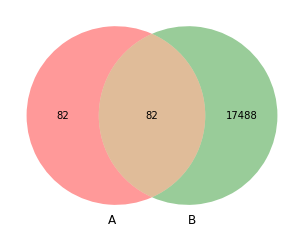

In [16]:
all_histone_genes = set(histone_genes['Ensembl gene ID']).union(set(histone_genes0['Ensembl gene ID']))
venn2_unweighted([all_histone_genes, expressed_genes])

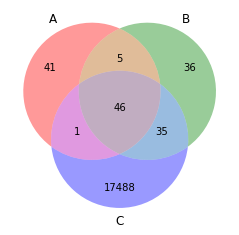

In [17]:
venn3_unweighted([set(histone_genes['Ensembl gene ID']), set(histone_genes0['Ensembl gene ID']), expressed_genes])

In [18]:
expressed_non_histone = expressed_genes.difference(all_histone_genes)  # green
histone_genes_set = expressed_genes.intersection(all_histone_genes)  # orange
print(len(expressed_non_histone), len(histone_genes_set))

17488 82


In [19]:
# histone_genes_set = set(histone_genes['name'])  # eric paper
# histone_genes_set = set(histone_genes['Ensembl gene ID'])  # hgnc
k562_idr_genes_set = set(k562_idr['geneid_trimmed'])
pslbp_idr_genes_set = set(pslbp_idr['geneid_trimmed'])
filtered_edits_genes_set = set(filtered_edits['geneid_trimmed'])
stamp_edits_poisson05_genes_set = set(stamp_edits_poisson05['geneid_trimmed'])
stamp_edits_poisson075_genes_set = set(stamp_edits_poisson075['geneid_trimmed'])
stamp_edits_poisson05_no_density_genes_set = set(stamp_edits_poisson05_no_density['geneid_trimmed'])
stamp_edits_poisson075_no_density_genes_set = set(stamp_edits_poisson075_no_density['geneid_trimmed'])

In [20]:
histone_genes_set.intersection(filtered_edits_genes_set)

{'ENSG00000099284',
 'ENSG00000105968',
 'ENSG00000113648',
 'ENSG00000115163',
 'ENSG00000124529',
 'ENSG00000124575',
 'ENSG00000124635',
 'ENSG00000124693',
 'ENSG00000132475',
 'ENSG00000158373',
 'ENSG00000158406',
 'ENSG00000163041',
 'ENSG00000164032',
 'ENSG00000168274',
 'ENSG00000168298',
 'ENSG00000180573',
 'ENSG00000180596',
 'ENSG00000181218',
 'ENSG00000182217',
 'ENSG00000183558',
 'ENSG00000183598',
 'ENSG00000183941',
 'ENSG00000184260',
 'ENSG00000184270',
 'ENSG00000184348',
 'ENSG00000184678',
 'ENSG00000184825',
 'ENSG00000184897',
 'ENSG00000185130',
 'ENSG00000187837',
 'ENSG00000187990',
 'ENSG00000188486',
 'ENSG00000188987',
 'ENSG00000189060',
 'ENSG00000196176',
 'ENSG00000196226',
 'ENSG00000196331',
 'ENSG00000196747',
 'ENSG00000196787',
 'ENSG00000196866',
 'ENSG00000196966',
 'ENSG00000197061',
 'ENSG00000197409',
 'ENSG00000197697',
 'ENSG00000197837',
 'ENSG00000197846',
 'ENSG00000197903',
 'ENSG00000197914',
 'ENSG00000198339',
 'ENSG00000198366',


In [21]:
comparisons = {
    'histones vs K562 IDR peaks': [
        [histone_genes_set, k562_idr_genes_set], 
        ['histone genes', 'k562 IDR genes']
    ],
    'histones vs PSLBP IDR peaks': [
        [histone_genes_set, pslbp_idr_genes_set], 
        ['histone genes', 'PSLBP IDR genes']
    ],
    'histones vs stamp_edits_poisson05_genes_set': [
        [histone_genes_set, stamp_edits_poisson05_genes_set], 
        ['histone genes', 'STAMP poisson 0.5 genes'] 
    ],
    'histones vs stamp_edits_poisson075_genes_set': [
        [histone_genes_set, stamp_edits_poisson075_genes_set], 
        ['histone genes', 'STAMP poisson 0.75 genes'] 
    ],
    'histones vs stamp_edits_poisson05_genes_set (no density)': [
        [histone_genes_set, stamp_edits_poisson05_no_density_genes_set], 
        ['histone genes', 'STAMP poisson 0.5 genes (no density)'] 
    ],
    'histones vs stamp_edits_poisson075_genes_set (no density)': [
        [histone_genes_set, stamp_edits_poisson075_no_density_genes_set], 
        ['histone genes', 'STAMP poisson 0.75 genes (no density)'] 
    ],
    'K562 IDR peaks vs stamp_edits_poisson05_genes_set': [
        [k562_idr_genes_set, stamp_edits_poisson05_genes_set], 
        ['k562 IDR genes', 'STAMP poisson 0.5 genes'] 
    ],
    'K562 IDR peaks vs stamp_edits_poisson05_genes_set': [
        [k562_idr_genes_set, stamp_edits_poisson075_genes_set], 
        ['k562 IDR genes', 'STAMP poisson 0.75 genes'] 
    ],
    'PSLBP IDR peaks vs stamp_edits_poisson05_genes_set': [
        [pslbp_idr_genes_set, stamp_edits_poisson05_genes_set], 
        ['PSLBP IDR genes', 'STAMP poisson 0.5 genes'] 
    ],
    'PSLBP IDR peaks vs stamp_edits_poisson075_genes_set': [
        [pslbp_idr_genes_set, stamp_edits_poisson075_genes_set], 
        ['PSLBP IDR genes', 'STAMP poisson 0.75 genes'] 
    ],
    'K562 IDR peaks vs stamp_edits_poisson075_genes_set (no density)': [
        [k562_idr_genes_set, stamp_edits_poisson075_no_density_genes_set], 
        ['k562 IDR genes', 'STAMP poisson 0.75 genes (no density)'] 
    ],
    'PSLBP IDR peaks vs stamp_edits_poisson075_genes_set (no density)': [
        [pslbp_idr_genes_set, stamp_edits_poisson075_no_density_genes_set], 
        ['PSLBP IDR genes', 'STAMP poisson 0.75 genes (no density)'] 
    ],
    'K562 IDR peaks vs adhoc-filtered SLBP': [
        [k562_idr_genes_set, filtered_edits_genes_set], 
        ['k562 IDR genes', 'Conf-filtered genes'] 
    ],
    'PSLBP IDR peaks vs adhoc-filtered SLBP': [
        [pslbp_idr_genes_set, filtered_edits_genes_set], 
        ['PSLBP IDR genes', 'Conf-filtered genes'] 
    ],
}

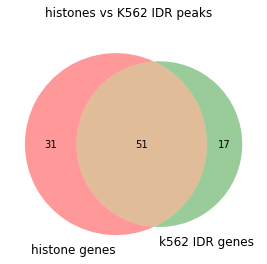

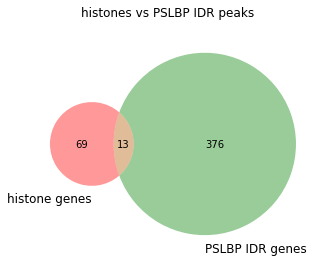

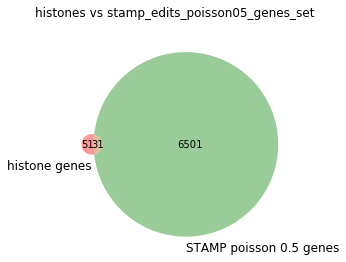

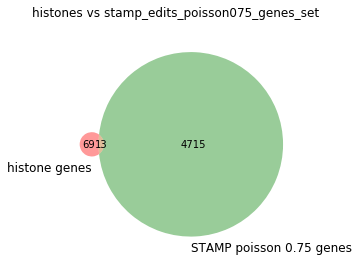

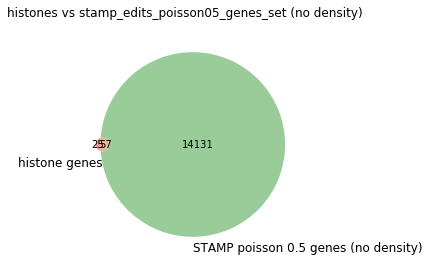

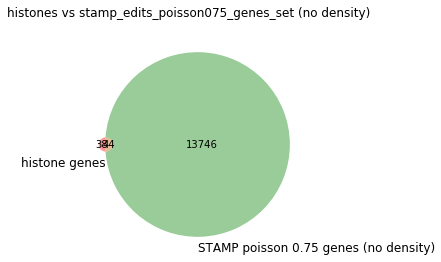

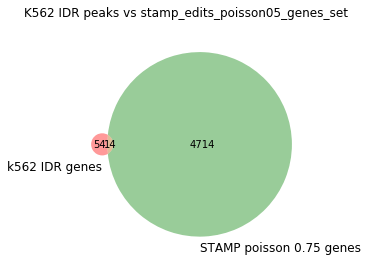

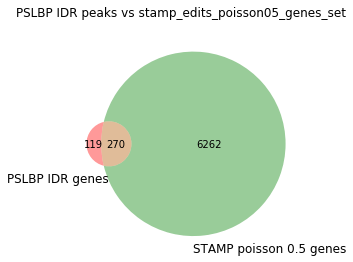

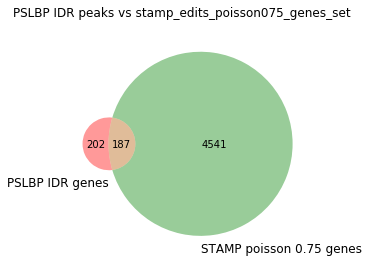

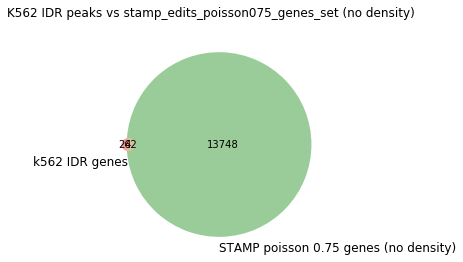

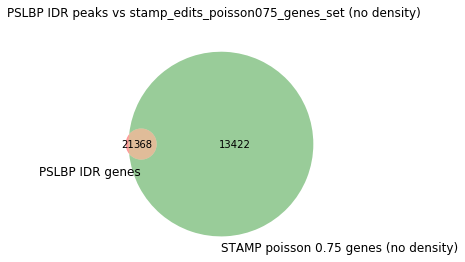

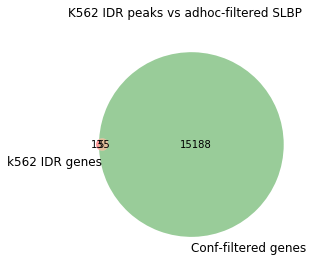

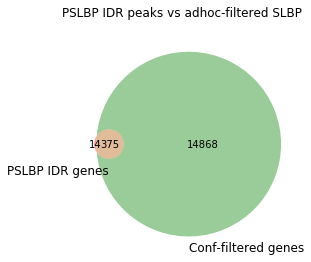

In [22]:
for label, genecomp in comparisons.items():
    fig, ax = plt.subplots()
    ax = venn2(genecomp[0], genecomp[1])
    fig.suptitle(label)

# Now perform 3way venn
- weighted and unweighted since the numbers end up squishing together

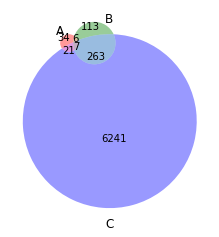

In [23]:
venn3([k562_idr_genes_set, pslbp_idr_genes_set, stamp_edits_poisson05_genes_set])

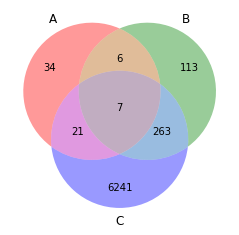

In [24]:
venn3_unweighted([k562_idr_genes_set, pslbp_idr_genes_set, stamp_edits_poisson05_genes_set])

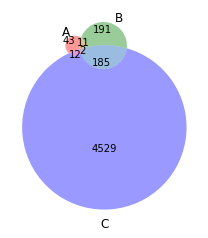

In [25]:
venn3([k562_idr_genes_set, pslbp_idr_genes_set, stamp_edits_poisson075_genes_set])

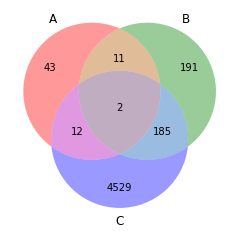

In [26]:
venn3_unweighted([k562_idr_genes_set, pslbp_idr_genes_set, stamp_edits_poisson075_genes_set])

# Let's try an EPKM filter to see if we can't whittle down some of the non-histone edits.

In [27]:
counts_table.head()

,Chr,Start,End,Strand,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/APOBEC_only_0_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/APOBEC_only_1000_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/APOBEC_only_50_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/RBFOX_0_48hr_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/RBFOX_0_72hr_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,...,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/RBFOX_50_72hr_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/SLBP_0_72hr_A_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/SLBP_0_72hr_B_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/SLBP_0_72hr_C_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/SLBP_1000_48hr_A_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/SLBP_1000_48hr_B_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/SLBP_1000_48hr_C_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/SLBP_1000_72hr_A_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/SLBP_1000_72hr_B_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,/home/bay001/projects/kris_apobec_20200121/permanent_data/20191220_rnaseq/results/SLBP_1000_72hr_C_merged_R1.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,11869;11872;11874;12010;12179;12595;12613;1261...,12227;12227;12227;12057;12227;12721;12697;1272...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,1756,8,1,1,8,3,...,5,5,2,1,7,3,5,7,6,5
ENSG00000227232,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14363;14363;14363;14404;14411;14970;14970;1497...,14829;14829;14829;14501;14502;15038;15038;1503...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,2073,2635,1751,1660,2464,2290,...,2649,1704,1963,1498,2426,2746,2672,2078,2536,2288
ENSG00000243485,chr1;chr1;chr1;chr1;chr1;chr1,29554;30267;30366;30564;30976;30976,30039;30667;30503;30667;31109;31097,+;+;+;+;+;+,1021,41,23,27,52,39,...,24,16,26,11,56,68,57,26,29,39
ENSG00000237613,chr1;chr1;chr1;chr1;chr1,34554;35245;35277;35721;35721,35174;35481;35481;36081;36073,-;-;-;-;-,1219,1,1,0,0,0,...,1,0,2,3,2,0,2,0,0,1
ENSG00000268020,chr1;chr1;chr1,52473;53049;54830,53312;53067;54936,+;+;+,947,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [28]:
filtered_edits['edited'] = filtered_edits['score'].apply(lambda x: int(x.split(',')[0]))
filtered_edits.head()

,chrom,start,end,name,score,strand,annotation,region_w_gene,geneid,genename,region_w_overlap,editfrac,geneid_trimmed,edited
0,chr1,322208,322209,0.904382,"1,11",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.090909,ENSG00000237094,1
1,chr1,324297,324298,0.972277,"2,27",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.074074,ENSG00000237094,2
2,chr1,324779,324780,0.922745,"1,9",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.111111,ENSG00000237094,1
3,chr1,324820,324821,0.817907,"1,21",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||lncRNA|lnc-OR4F29-1||ENSG00000...,lncRNA|lnc-OR4F29-1||ENSG00000237094.7,lnc-OR4F29-1|RP4-669L17.10,noncoding_exon|1,0.047619,ENSG00000237094,1
4,chr1,327502,327503,0.886385,"1,13",+,noncoding_exon;lncRNA|lnc-OR4F29-1||noncoding_...,noncoding_exon||ENSG00000250575.1||lncRNA|lnc-...,ENSG00000250575.1||lncRNA|lnc-OR4F29-1,RP4-669L17.8|lnc-OR4F29-1,noncoding_exon|1,0.076923,ENSG00000250575,1


In [29]:
edit_counts = pd.DataFrame(filtered_edits.groupby('geneid_trimmed')['edited'].sum())
edit_counts.head()

,edited
geneid_trimmed,
ENSG00000000003,4
ENSG00000000419,2
ENSG00000000457,1
ENSG00000000460,11
ENSG00000001036,8


In [30]:
edit_counts_length = pd.merge(edit_counts, counts_table[['Length']], how='outer', left_index=True, right_index=True).fillna(0)
edit_counts_length.sort_values(by='edited', ascending=False).head()

,edited,Length
ENSG00000229807,278.0,19931.0
lncRNA|SERTAD4-AS1||lncRNA|lnc-OR4F29-8,192.0,0.0
ENSG00000188681,137.0,2927.0
lncRNA|LENG8-AS1,132.0,0.0
lncRNA|KANSL1-AS1||lncRNA|MAPT-IT1,128.0,0.0


In [31]:
def epkm(row, total_mapped, colname='edited'):
    """
    Just like "RPKM" except we're looking at the number of edits (edit_counts).
    edit_counts = total number of edit conversions across a genic region (all exons, or 3'UTR+CDS, or CDS)
    If a read contains multiple C>T conversions, we end up counting it multiple times. Perhaps that's okay?
    """
    edit_counts = row[colname]
    return edit_counts/((total_mapped/1000000.)*(row['Length']/1000.))

edit_counts_length['epkm'] = edit_counts_length.apply(epkm, args=(108410275, ), axis=1, )  # total mapped for SLBP_1000_72hr_merged

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


In [32]:
edit_counts_length = edit_counts_length[edit_counts_length['Length']>0] # gets rid of lncRNA annotations, which aren't standard.
edit_counts_length.sort_values(by='epkm', inplace=True, ascending=False)
edit_counts_length.head()

,edited,Length,epkm
ENSG00000210195,28.0,66.0,3.913305
ENSG00000269900,23.0,268.0,0.791631
ENSG00000260548,34.0,563.0,0.557058
ENSG00000198763,56.0,1042.0,0.495735
ENSG00000198886,71.0,1378.0,0.475268


In [33]:
genesets = {}
for threshold in [
    100, 200, 300, 500, 1000, 5000, 10000
]:
    genesets[threshold] = set(edit_counts_length.head(threshold).index)

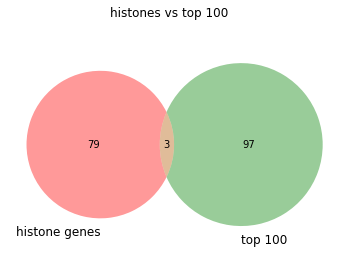

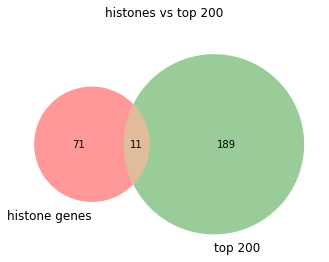

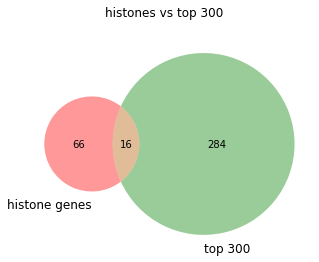

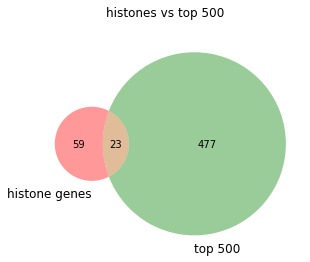

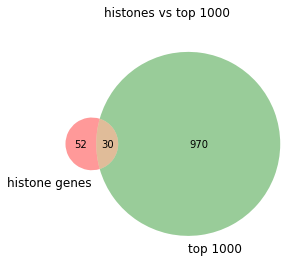

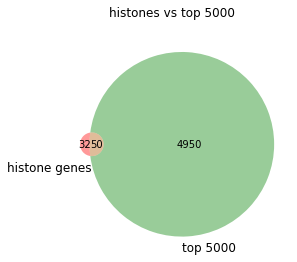

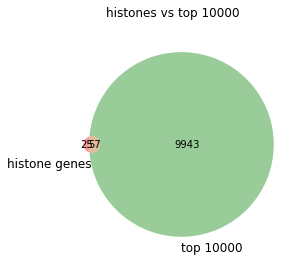

In [34]:
comparisons = {
    'histones vs top 100': [
        [histone_genes_set, genesets[100]], 
        ['histone genes', 'top 100']
    ],
    'histones vs top 200': [
        [histone_genes_set, genesets[200]], 
        ['histone genes', 'top 200']
    ],
    'histones vs top 300': [
        [histone_genes_set, genesets[300]], 
        ['histone genes', 'top 300']
    ],
    'histones vs top 500': [
        [histone_genes_set, genesets[500]], 
        ['histone genes', 'top 500']
    ],
    'histones vs top 1000': [
        [histone_genes_set, genesets[1000]], 
        ['histone genes', 'top 1000']
    ],
    'histones vs top 5000': [
        [histone_genes_set, genesets[5000]], 
        ['histone genes', 'top 5000']
    ],
    'histones vs top 10000': [
        [histone_genes_set, genesets[10000]], 
        ['histone genes', 'top 10000']
    ],
}
for label, genecomp in comparisons.items():
    fig, ax = plt.subplots()
    ax = venn2(genecomp[0], genecomp[1])
    fig.suptitle(label)

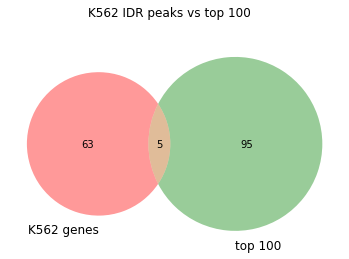

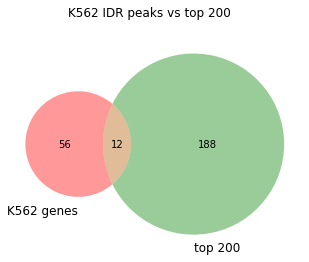

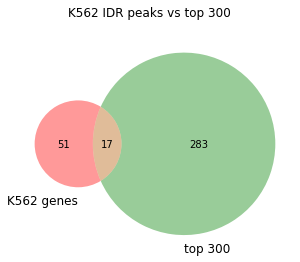

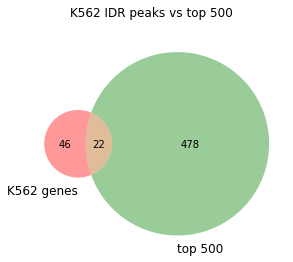

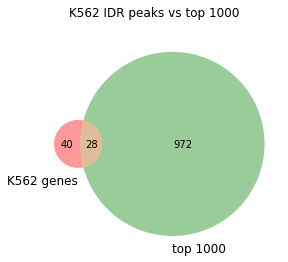

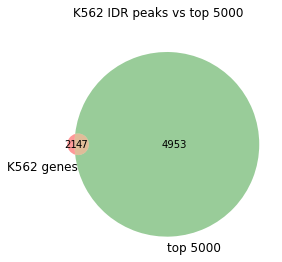

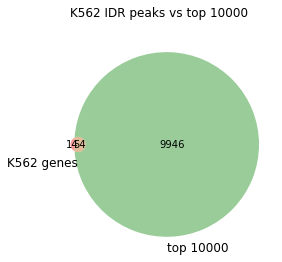

In [35]:
comparisons = {
    'K562 IDR peaks vs top 100': [
        [k562_idr_genes_set, genesets[100]], 
        ['K562 genes', 'top 100']
    ],
    'K562 IDR peaks vs top 200': [
        [k562_idr_genes_set, genesets[200]], 
        ['K562 genes', 'top 200']
    ],
    'K562 IDR peaks vs top 300': [
        [k562_idr_genes_set, genesets[300]], 
        ['K562 genes', 'top 300']
    ],
    'K562 IDR peaks vs top 500': [
        [k562_idr_genes_set, genesets[500]], 
        ['K562 genes', 'top 500']
    ],
    'K562 IDR peaks vs top 1000': [
        [k562_idr_genes_set, genesets[1000]], 
        ['K562 genes', 'top 1000']
    ],
    'K562 IDR peaks vs top 5000': [
        [k562_idr_genes_set, genesets[5000]], 
        ['K562 genes', 'top 5000']
    ],
    'K562 IDR peaks vs top 10000': [
        [k562_idr_genes_set, genesets[10000]], 
        ['K562 genes', 'top 10000']
    ],
}
for label, genecomp in comparisons.items():
    fig, ax = plt.subplots()
    ax = venn2(genecomp[0], genecomp[1])
    fig.suptitle(label)

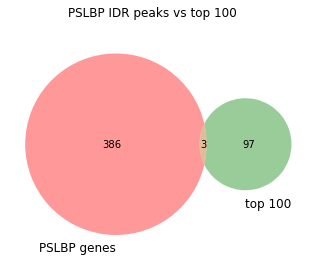

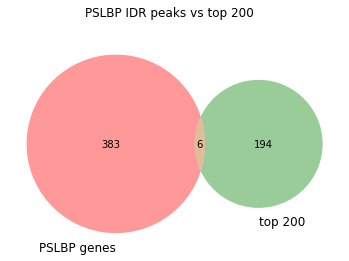

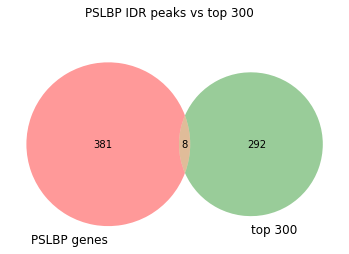

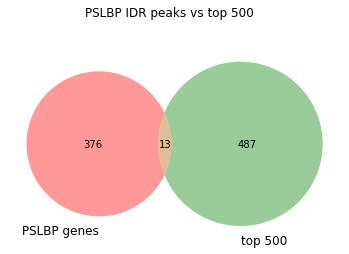

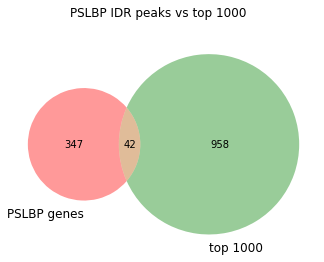

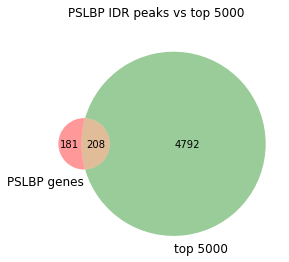

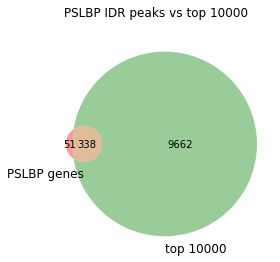

In [36]:
comparisons = {
    'PSLBP IDR peaks vs top 100': [
        [pslbp_idr_genes_set, genesets[100]], 
        ['PSLBP genes', 'top 100']
    ],
    'PSLBP IDR peaks vs top 200': [
        [pslbp_idr_genes_set, genesets[200]], 
        ['PSLBP genes', 'top 200']
    ],
    'PSLBP IDR peaks vs top 300': [
        [pslbp_idr_genes_set, genesets[300]], 
        ['PSLBP genes', 'top 300']
    ],
    'PSLBP IDR peaks vs top 500': [
        [pslbp_idr_genes_set, genesets[500]], 
        ['PSLBP genes', 'top 500']
    ],
    'PSLBP IDR peaks vs top 1000': [
        [pslbp_idr_genes_set, genesets[1000]], 
        ['PSLBP genes', 'top 1000']
    ],
    'PSLBP IDR peaks vs top 5000': [
        [pslbp_idr_genes_set, genesets[5000]], 
        ['PSLBP genes', 'top 5000']
    ],
    'PSLBP IDR peaks vs top 10000': [
        [pslbp_idr_genes_set, genesets[10000]], 
        ['PSLBP genes', 'top 10000']
    ],
}
for label, genecomp in comparisons.items():
    fig, ax = plt.subplots()
    ax = venn2(genecomp[0], genecomp[1])
    fig.suptitle(label)

# No that doesn't really work. Looking at our data, maybe if we subtract?

In [37]:
edits_bedtool = pybedtools.BedTool.from_dataframe(filtered_edits[['chrom','start','end','geneid_trimmed','edited','strand']])

In [38]:
filtered_edits[['chrom','start','end','geneid_trimmed','edited','strand']].head()

,chrom,start,end,geneid_trimmed,edited,strand
0,chr1,322208,322209,ENSG00000237094,1,+
1,chr1,324297,324298,ENSG00000237094,2,+
2,chr1,324779,324780,ENSG00000237094,1,+
3,chr1,324820,324821,ENSG00000237094,1,+
4,chr1,327502,327503,ENSG00000250575,1,+


In [39]:
control_bedtool = pybedtools.BedTool.from_dataframe(stamp_control[['chrom','start','end','name','score','strand']])

In [40]:
filtered_edits = edits_bedtool.subtract(control_bedtool, s=True).to_dataframe()
print(edits_bedtool.to_dataframe().shape[0], filtered_edits.shape[0])

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


100351 98240


In [41]:
filtered_edits.head()

,chrom,start,end,name,score,strand
0,chr1,324779,324780,ENSG00000237094,1,+
1,chr1,324820,324821,ENSG00000237094,1,+
2,chr1,327502,327503,ENSG00000250575,1,+
3,chr1,327729,327730,ENSG00000250575,1,+
4,chr1,564545,564546,ENSG00000225972,2,+


In [42]:
edit_counts = pd.DataFrame(filtered_edits.groupby('name')['score'].sum())
edit_counts.head()

,score
name,
ENSG00000000003,4
ENSG00000000419,2
ENSG00000000457,1
ENSG00000000460,11
ENSG00000001036,8


In [43]:
edit_counts_length = pd.merge(edit_counts, counts_table[['Length']], how='outer', left_index=True, right_index=True).fillna(0)
edit_counts_length.sort_values(by='score', ascending=False).head()

,score,Length
ENSG00000229807,222.0,19931.0
lncRNA|SERTAD4-AS1||lncRNA|lnc-OR4F29-8,165.0,0.0
lncRNA|LENG8-AS1,127.0,0.0
lncRNA|lnc-CHL1-7,120.0,0.0
lncRNA|WEE2-AS1,108.0,0.0


In [44]:
edit_counts_length['epkm'] = edit_counts_length.apply(epkm, args=(108410275, 'score'), axis=1, )  # total mapped for SLBP_1000_72hr_merged

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


In [45]:
edit_counts_length = edit_counts_length[edit_counts_length['Length']>0] # gets rid of lncRNA annotations, which aren't standard.
edit_counts_length.sort_values(by='epkm', inplace=True, ascending=False)
edit_counts_length.head()

,score,Length,epkm
ENSG00000260548,34.0,563.0,0.557058
ENSG00000240036,18.0,376.0,0.441585
ENSG00000238741,15.0,330.0,0.419283
ENSG00000233799,10.0,286.0,0.322525
ENSG00000227615,11.0,399.0,0.254302


In [46]:
genesets = {}
for threshold in [
    100, 200, 300, 500, 1000, 5000, 10000
]:
    genesets[threshold] = set(edit_counts_length.head(threshold).index)

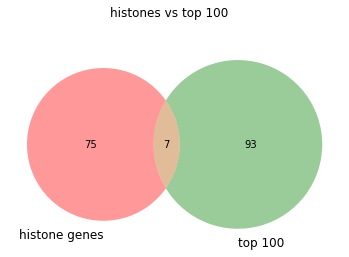

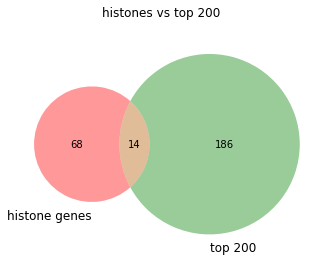

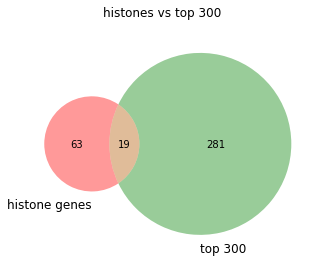

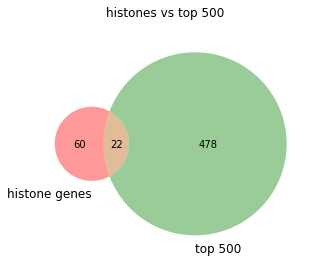

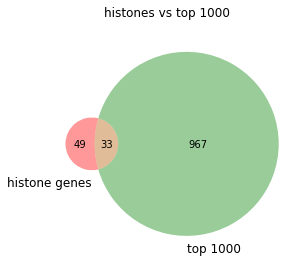

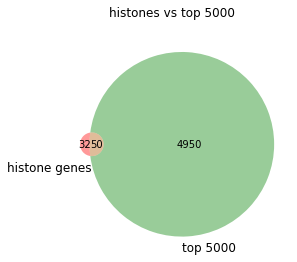

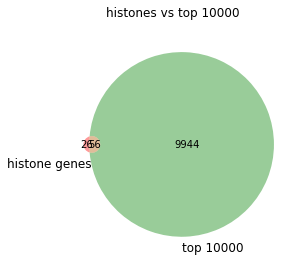

In [47]:
comparisons = {
    'histones vs top 100': [
        [histone_genes_set, genesets[100]], 
        ['histone genes', 'top 100']
    ],
    'histones vs top 200': [
        [histone_genes_set, genesets[200]], 
        ['histone genes', 'top 200']
    ],
    'histones vs top 300': [
        [histone_genes_set, genesets[300]], 
        ['histone genes', 'top 300']
    ],
    'histones vs top 500': [
        [histone_genes_set, genesets[500]], 
        ['histone genes', 'top 500']
    ],
    'histones vs top 1000': [
        [histone_genes_set, genesets[1000]], 
        ['histone genes', 'top 1000']
    ],
    'histones vs top 5000': [
        [histone_genes_set, genesets[5000]], 
        ['histone genes', 'top 5000']
    ],
    'histones vs top 10000': [
        [histone_genes_set, genesets[10000]], 
        ['histone genes', 'top 10000']
    ],
}
for label, genecomp in comparisons.items():
    fig, ax = plt.subplots()
    ax = venn2(genecomp[0], genecomp[1])
    fig.suptitle(label)